In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [32]:
def non_maximum_suppression(points, image):
  height, width, _ = image.shape
  binary_mask = np.zeros((height, width), dtype=np.uint8)
  responses = np.array([point.response for point in points])
  mask = np.flip(np.argsort(responses))

  point_list = np.rint([point.pt for point in points])[mask].astype(int)

  nms_mask = []
  for point, index in zip(point_list, mask):
      if binary_mask[point[1], point[0]] == 0:
          nms_mask.append(index)
          cv2.circle(binary_mask, tuple(point), 2, 255, -1)

  return nms_mask

def get_corresp_pts(image1, image2, sift, draw_matches=False):

  kp1, des1 = sift.detectAndCompute(image1, None)
  nms_mask = non_maximum_suppression(kp1, image1)
  kp1 = np.array(kp1)[nms_mask]
  des1 = np.array(des1)[nms_mask]

  kp2, des2 = sift.detectAndCompute(image2, None)
  nms_mask = non_maximum_suppression(kp2, image2)
  kp2 = np.array(kp2)[nms_mask]
  des2 = np.array(des2)[nms_mask]

  # Find matches
  matcher = cv2.BFMatcher(cv2.NORM_L2)
  matches = matcher.knnMatch(des1, des2, k=2)

  # Apply ratio test
  good_matches = []
  for m, n in matches:
      if m.distance < 0.75*n.distance:
          good_matches.append(m)

  src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

  if(draw_matches):
    im1 = image1
    im2 = image2
    matching_result = cv2.drawMatches(im1, kp1, im2, kp2,
    good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.title('Feature Matching Result')
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    plt.axis('off')


  return src_pts, dst_pts, good_matches



def normalize_points(points):

    # Normalize points to have zero mean and a mean distance of sqrt(2) from the origin
    mean = np.mean(points, axis=0)

    dist = np.sqrt(2) / np.sqrt(np.mean(np.sum((points - mean) ** 2, axis=1)))

    T = np.array([[dist, 0, -dist * mean[1]],
                  [0, dist, -dist * mean[1]],
                  [0, 0, 1]])

    normalized_points = np.hstack((points, np.ones((points.shape[0], 1))))
    normalized_points = (T @ normalized_points.T).T

    return normalized_points, T



def compute_fundamental_matrix(points1, points2):
    if len(points1) < 8 or len(points2) < 8:
        raise ValueError("Insufficient correspondences to compute the fundamental matrix.")

    points1, T1 = normalize_points(points1)
    points2, T2 = normalize_points(points2)

    A = np.zeros((len(points1), 9))
    for i in range(len(points1)):
        u1, v1, _ = points1[i]
        u2, v2, _ = points2[i]
        A[i] = [u2 * u1, u2 * v1, u2, v2 * u1, v2 * v1, v2, u1, v1, 1]

    # Solve the homogeneous system of equations using SVD
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)

    # Enforce rank-2 constraint
    U, S, Vt = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vt

    # Denormalize the fundamental matrix
    F = T2.T @ F @ T1

    return F


def compute_essential_mat(img1_pts, img2_pts):
      E, mask = cv2.findEssentialMat(img1_pts, img2_pts, K, cv2.RANSAC, 0.999, 1.0)
      img1_pts = img1_pts[mask.ravel() == 1]
      img2_pts = img2_pts[mask.ravel() == 1]

      return E, img1_pts, img2_pts, mask



def draw_epipolar_lines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''

    r,c, _ = img1.shape

    for r,pt1,pt2 in zip(lines,pts1,pts2):

        pt1 = (int(pt1[0]),int(pt1[1]))
        pt2 = (int(pt2[0]),int(pt2[1]))

        color = tuple(np.random.randint(0,255,3).tolist())

        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        img1_temp = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1_temp = cv2.circle(img1_temp, pt1, 5, color, -1)
        img2_temp = cv2.circle(img2, pt2, 5, color, -1)

    return img1_temp, img2_temp



def calc_P1_P2(E, K, img1_pts, img2_pts):

    U, _, Vt = np.linalg.svd(E)

    Y = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = U @ Y @ Vt
    R2 = U @ Y.T @ Vt

    T1 = U[:, 2]
    T2 = -1*U[:, 2]

    R_T_list = [(R1,T1), (R1,T2), (R2,T1), (R2,T2)]

    for i, (R, T) in enumerate(R_T_list):
      if np.linalg.det(R) < 0:
        R_T_list[i] = (-1*R, -1*T)


    num_pos_pts = []
    for (R, T) in R_T_list:
        pos_pts = 0

        P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = K @ np.hstack((R, T.reshape(3, 1)))

        for pt1, pt2 in zip(img1_pts, img2_pts):

            X = cv2.triangulatePoints(P1, P2, pt1, pt2)
            X /= X[3]
            X = X[0:3,:]

            chi1 = X[2]
            chi2 = R[2,:]@(X-np.reshape(T, X.shape))

            if(chi1>0 and chi2>0):
                pos_pts+=1

        num_pos_pts.append(pos_pts)

    idx = np.argmax(num_pos_pts)
    (R, T) = R_T_list[idx]

    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, T.reshape(3, 1)))

    return P1, P2, R, T


def triangulate_points(P1, P2, img1_pts, img2_pts):
  pts_3d = cv2.triangulatePoints(P1, P2, img1_pts.T, img2_pts.T)
  pts_3d = pts_3d/pts_3d[3]
  pts_3d = pts_3d[:3,:]

  mask = pts_3d[2, :] > 0
  pts_3d = pts_3d[:, mask]
  img1_pts = img1_pts[mask]
  img2_pts = img2_pts[mask]

  return pts_3d.T, img1_pts, img2_pts



def plot_3d_points(points_3d):
    total_colors = np.zeros((1, 3))
    x=points_3d[:, 0]
    y=points_3d[:, 1]
    z=points_3d[:, 2]

    fig = go.Figure()

    scatter = fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=1.2, color=total_colors/255)))

    fig.show()



def plot_poses(r_t_list, final=False):
    # Initialize 3D subplot
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    # Loop through all poses
    for i, (R, T) in enumerate(r_t_list):
      if not final:
        # Calculate camera pose
        if i == 0:
            camera_pose = np.eye(4)
        else:
            relative_pose = np.eye(4)
            relative_pose[:3, :3] = R
            relative_pose[:3, 3] = T
            camera_pose = np.dot(camera_pose, relative_pose)

        # Extract camera position
        camera_position = camera_pose[:3, 3]

      else:
        camera_pose = np.eye(4)
        camera_pose[:3, :3] = R
        camera_pose[:3, 3] = T
        camera_position = T
      # Add scatter point for camera position
      fig.add_trace(
          go.Scatter3d(
              x=[camera_position[0]],
              y=[camera_position[1]],
              z=[camera_position[2]],
              mode='markers',
              marker=dict(size=5, color='blue'),
              name=f'Pose {i+1}'
          )
      )

      # Add lines for axes
      scale = 0.3
      x_axis = camera_pose @ np.array([scale, 0, 0, 1])
      y_axis = camera_pose @ np.array([0, scale, 0, 1])
      z_axis = camera_pose @ np.array([0, 0, scale, 1])

      fig.add_trace(
          go.Scatter3d(
              x=[camera_position[0], x_axis[0]],
              y=[camera_position[1], x_axis[1]],
              z=[camera_position[2], x_axis[2]],
              mode='lines',
              line=dict(color='red'),
              showlegend=False
          )
      )

      fig.add_trace(
          go.Scatter3d(
              x=[camera_position[0], y_axis[0]],
              y=[camera_position[1], y_axis[1]],
              z=[camera_position[2], y_axis[2]],
              mode='lines',
              line=dict(color='green'),
              showlegend=False
          )
      )

      fig.add_trace(
          go.Scatter3d(
              x=[camera_position[0], z_axis[0]],
              y=[camera_position[1], z_axis[1]],
              z=[camera_position[2], z_axis[2]],
              mode='lines',
              line=dict(color='blue'),
              showlegend=False
          )
      )

    # Set layout
    fig.update_layout(
        scene=dict(
            aspectmode="cube",
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        title='Camera Poses'
    )

    # Show the plot
    fig.show()



def final_poses(r_t_list):

  final_list = []
  for i, (R,T) in enumerate(r_t_list):
      # Calculate the camera pose for the current image using R and T
      if i == 0:
          # The first camera pose is the reference pose (e.g., origin)
          camera_pose = np.eye(4)
          R = camera_pose[:3, :3]
          T = camera_pose[:3, 3]
          final_list.append((R,T))

      else:
          # Calculate the camera pose using the relative transformation (R and T)
          relative_pose = np.eye(4)
          relative_pose[:3, :3] = R
          relative_pose[:3, 3] = T
          camera_pose = np.dot(camera_pose, relative_pose)

          R = camera_pose[:3, :3]
          T = camera_pose[:3, 3]
          final_list.append((R,T))

  return final_list


def refine_camera_pose_PNP(pts_3d, pts_2d, K):
        success, rvec, t, inliers = cv2.solvePnPRansac(pts_3d, pts_2d, K, None)

        if success:
            R, _ = cv2.Rodrigues(rvec)

        T_c_w = make_transformation_mat(R, t)

        return T_c_w


# Referred from Aniket's SFM pipeline
def common_pts(idx, prev_kpts, img1_pts, pt_cloud):
  match_2d = []
  match_3d = []
  match_idx = []

  for i, point in enumerate(img1_pts):
    for prev_pt in prev_kpts:
      if np.array_equal(point, prev_pt):
        match_2d.append(point)
        match_idx.append(i)

  for i, point in enumerate(match_2d):
    for point_3d in pt_cloud.keys():
      try:
        if np.array_equal(point, pt_cloud[point_3d][idx]):
          match_3d.append(point_3d)
          break
      except KeyError:
        continue

  match_2d = np.array(match_2d, dtype=np.float32)
  match_3d = np.array(match_3d, dtype=np.float32)

  return match_2d, match_3d, match_idx


def create_pt_cloud(pts_3d):
  pt_cloud = {}
  for i, point in enumerate(pts_3d):
    pt_cloud[tuple(point)] = {0:img1_pts[i], 1:img2_pts[i]}

  return pt_cloud


def update_pt_cloud(idx, pts_3d, img1_pts, img2_pts, pt_cloud):
  for i, point_3d in enumerate(pts_3d):
    point = (tuple(point_3d), {idx: img1_pts[i], idx+1: img2_pts[i]})
    pt_cloud[point[0]] = point[1]

  return pt_cloud


def make_transformation_mat(r,t):
  T = np.eye(4, dtype=np.float64)
  T[:3, :3] = r
  T[:3, 3] = t if t.ndim == 1 else t.ravel()
  return T




Total imgs = 24


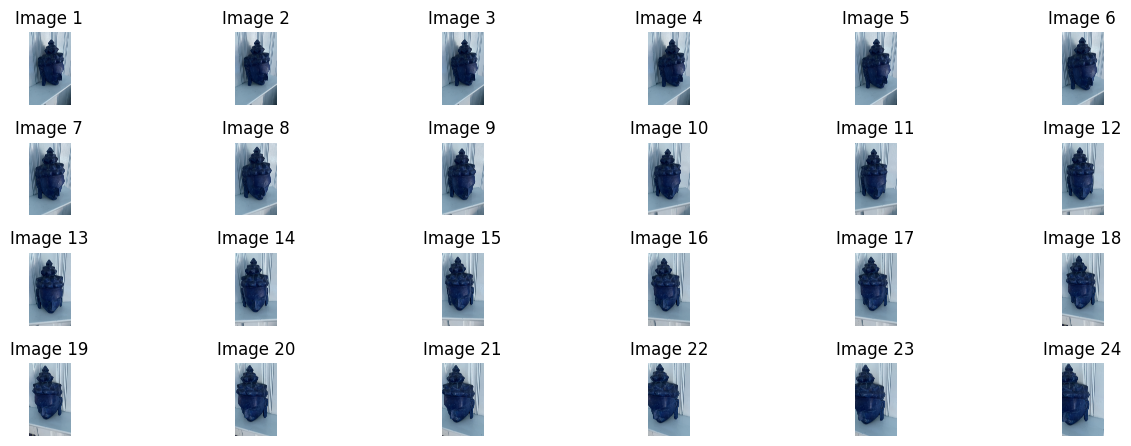

In [42]:
#Reading images
root_dir = "/content/"
NUM_IMGS = 24
img_list = [cv2.imread(root_dir + str(i) + ".png") for i in range(1,NUM_IMGS+1)]
print("Total imgs =", len(img_list))

for i, img in enumerate(img_list):
    plt.subplot(4, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 2, 0.95])
plt.show()

In [43]:
sift = cv2.SIFT_create(nfeatures=1000, nOctaveLayers=3, contrastThreshold=0.04)

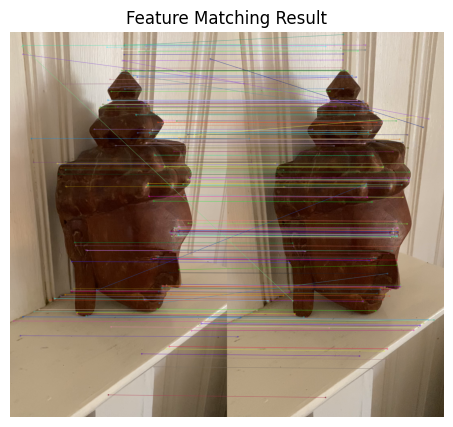

In [44]:
index = 1
_, _, g_matches = get_corresp_pts(img_list[index], img_list[index+1], sift, draw_matches=True)

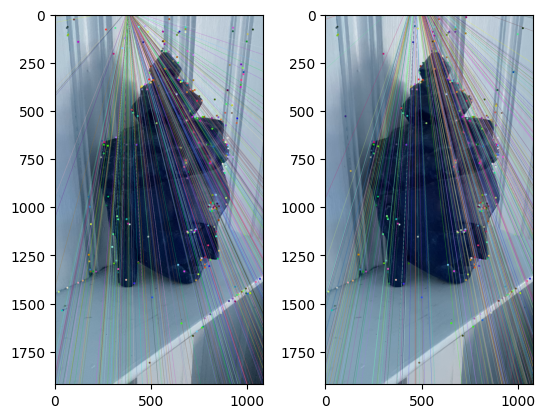

In [45]:
im_1 = np.copy(img_list[0])
im_2 = np.copy(img_list[1])

img1_pts, img2_pts, _ = get_corresp_pts(im_1, im_2, sift)

F_scratch = compute_fundamental_matrix(img1_pts, img2_pts)
F_scratch = F_scratch/F_scratch[2][2]

lines1 = cv2.computeCorrespondEpilines(img2_pts.reshape(-1,1,2), 2, F_scratch)
lines1 = lines1.reshape(-1,3)
im5,im6 = draw_epipolar_lines(im_1, im_2, lines1, img1_pts, img2_pts)

lines2 = cv2.computeCorrespondEpilines(img1_pts.reshape(-1,1,2), 1, F_scratch)
lines2 = lines2.reshape(-1,3)
im3,im4 = draw_epipolar_lines(im_2, im_1, lines2, img2_pts, img1_pts)
plt.subplot(121),plt.imshow(im5)
plt.subplot(122),plt.imshow(im3)
plt.show()

In [46]:
NUM_IMGS = 24
height, width, _ = img_list[0].shape
K = np.array([[1500, 0, width/2], [0, 1500, height/2], [0, 0, 1]], dtype=np.float32)

r_t_list = [(np.eye(3), np.array([0,0,0]))]
corresponding_pts_ls = []

for i in range(NUM_IMGS-1):

    img1_pts, img2_pts, good_matches = get_corresp_pts(img_list[i], img_list[i+1], sift)
    corresponding_pts_ls.append((img1_pts, img2_pts, good_matches))
    print(f'number of good matches between image {i} and image {i+1} = ', len(good_matches))

    E, img1_pts, img2_pts, _ = compute_essential_mat(img1_pts, img2_pts)

    _, P2, R, T = calc_P1_P2(E, K, img1_pts, img2_pts)
    r_t_list.append((R,T))

final_r_t_ls = final_poses(r_t_list)

number of good matches between image 0 and image 1 =  276
number of good matches between image 1 and image 2 =  193
number of good matches between image 2 and image 3 =  195
number of good matches between image 3 and image 4 =  99
number of good matches between image 4 and image 5 =  104
number of good matches between image 5 and image 6 =  125
number of good matches between image 6 and image 7 =  118
number of good matches between image 7 and image 8 =  99
number of good matches between image 8 and image 9 =  116
number of good matches between image 9 and image 10 =  123
number of good matches between image 10 and image 11 =  105
number of good matches between image 11 and image 12 =  129
number of good matches between image 12 and image 13 =  87
number of good matches between image 13 and image 14 =  78
number of good matches between image 14 and image 15 =  136
number of good matches between image 15 and image 16 =  158
number of good matches between image 16 and image 17 =  149
num

In [47]:
plot_poses(final_r_t_ls, final=True)

In [48]:
poses_dict = {}
for idx in range(len(corresponding_pts_ls)):
  if(idx==0):
    img1_pts, img2_pts, good_matches = corresponding_pts_ls[idx]

    E, img1_pts, img2_pts, _ = compute_essential_mat(img1_pts, img2_pts)

    P1, P2, R, T = calc_P1_P2(E, K, img1_pts, img2_pts)

    T_mat = make_transformation_mat(R,T)

    poses_dict[f'w_{0}'] = np.eye(4)
    poses_dict[f'w_{1}'] = T_mat

    pts_3d, img1_pts, img2_pts = triangulate_points(P1, P2, img1_pts, img2_pts)

    prev_kpts = img2_pts

    pt_cloud = create_pt_cloud(pts_3d)

  else:
    img1_pts, img2_pts, good_matches = corresponding_pts_ls[idx]
    print("Num of 2D points from Feature matching: ", img1_pts.shape)

    E, img1_pts, img2_pts, _ = compute_essential_mat(img1_pts, img2_pts)
    print("Num of 2D points after calculating E: ", img1_pts.shape)

    _, match_3d, match_idx = common_pts(idx, prev_kpts, img1_pts, pt_cloud)

    common_pts_image2 = img2_pts[match_idx]

    print("Num of 3D and 2D points from common points: ", match_3d.shape, " ", common_pts_image2.shape)
    T = refine_camera_pose_PNP(match_3d, common_pts_image2, K)
    poses_dict[f'w_{idx+1}'] = T

    P1 = K @ poses_dict[f'w_{idx}'][:3,:]
    P2 = K @ poses_dict[f'w_{idx+1}'][:3,:]

    pts_3d, img1_pts, img2_pts = triangulate_points(P1, P2, img1_pts, img2_pts)

    pt_cloud = update_pt_cloud(idx, pts_3d, img1_pts, img2_pts, pt_cloud)

    prev_kpts = img2_pts

Num of 2D points from Feature matching:  (193, 2)
Num of 2D points after calculating E:  (138, 2)
Num of 3D and 2D points from common points:  (82, 3)   (82, 2)
Num of 2D points from Feature matching:  (195, 2)
Num of 2D points after calculating E:  (145, 2)
Num of 3D and 2D points from common points:  (70, 3)   (70, 2)
Num of 2D points from Feature matching:  (99, 2)
Num of 2D points after calculating E:  (44, 2)
Num of 3D and 2D points from common points:  (18, 3)   (18, 2)
Num of 2D points from Feature matching:  (104, 2)
Num of 2D points after calculating E:  (50, 2)
Num of 3D and 2D points from common points:  (15, 3)   (15, 2)
Num of 2D points from Feature matching:  (125, 2)
Num of 2D points after calculating E:  (61, 2)
Num of 3D and 2D points from common points:  (19, 3)   (19, 2)
Num of 2D points from Feature matching:  (118, 2)
Num of 2D points after calculating E:  (73, 2)
Num of 3D and 2D points from common points:  (23, 3)   (23, 2)
Num of 2D points from Feature matching:

In [49]:
final_3d_pts = []
for pt_3d in pt_cloud.keys():
  final_3d_pts.append(pt_3d)

final_3d_pts = np.array(final_3d_pts)
print(final_3d_pts.shape)
plot_3d_points(final_3d_pts)

(1840, 3)


In [11]:
pip install gtsam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 50.4 MB/s eta 0:00:00


In [50]:
import gtsam
from gtsam import symbol_shorthand
from gtsam import (Cal3_S2, GenericProjectionFactorCal3_S2, NonlinearFactorGraph,
                PinholeCameraCal3_S2, Point3, Pose3, PriorFactorPoint3, PriorFactorPose3, Values)
from gtsam.utils import plot


# Landmarks
L = symbol_shorthand.L

# Poses
X = symbol_shorthand.X

# Define the camera calibration parameters
K = np.array([[1500, 0, width/2], [0, 1500, height/2], [0, 0, 1]], dtype=np.float32)

gtsam_camera_matrix = gtsam.Cal3_S2(K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

# GTSAM format (points and poses)
points = []
for pt in pt_cloud.keys():
    points.append(np.array(pt))

poses = []
for t in poses_dict.values():
    poses.append(Pose3(t[:3,:]))

# Create a factor graph
graph = NonlinearFactorGraph()

pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

for i, pose in enumerate(poses):
  camera = PinholeCameraCal3_S2(pose, gtsam_camera_matrix)
  for j, point in enumerate(points):
    try:
      measurement = camera.project(point)
      factor = GenericProjectionFactorCal3_S2(measurement, measurement_noise, X(i), L(j), gtsam_camera_matrix)
      graph.push_back(factor)
    except RuntimeError:
      continue

point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)

initial_estimate = Values()
for i, pose in enumerate(poses):
  transformed_pose = pose.retract(0.01*np.random.randn(6, 1))
  initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
  transformed_point = point + 0.01*np.random.randn(3)
  initial_estimate.insert(L(j), transformed_point)

params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

result = optimizer.optimize()

In [51]:
optimized_pt_cloud = []
for i, pt in enumerate(pt_cloud.keys()):
    optimized_pt_cloud.append(list(result.atPoint3(L(i))))

optimized_pt_cloud = np.array(optimized_pt_cloud)

In [52]:
optimized_poses = []
for i in range(NUM_IMGS):
  poses_dict[f'w_{i}'] = result.atPose3(X(i)).matrix()
  R = poses_dict[f'w_{i}'][:3,:3]
  T = poses_dict[f'w_{i}'][:3,3]
  optimized_poses.append((R, T))

print(len(optimized_poses))
plot_poses(optimized_poses, final=True)

24


In [53]:
plot_3d_points(optimized_pt_cloud)